# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

A intenção por trás desse notebook é fazer uma análise exploratória de dados utilizando como base de dados o dataset da empresa Loggi, uma empresa grande de logística aqui do Brasil.

Aqui faremos a exploração e uma breve manipulação dos dados para que seja possivel transformar um arquivo json em toda sua complexidade em um DataFrame pandas. 

## 2\. Pacotes e bibliotecas

In [1]:
!pip install wget
!pip3 install geopandas
!pip install geopy

In [2]:
import json

import wget
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

## 3\. Exploração de dados

In [3]:
# Importação do arquivo .json da Loggi
wget.download("https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json")
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

Na sequência, o próximo passo envolve  verificar a composição desse arquivo json, agora salvo na variavel data. Para isso, foi pego a primeira linha de cada coluna como amostra para melhor compreensão.

In [4]:
len(data)

199

In [5]:
example = data[0]

In [6]:
example['name']

'cvrp-2-df-33'

In [7]:
example['region']

'df-2'

In [8]:
example['origin']

{'lng': -48.05498915846707, 'lat': -15.83814451122274}

In [9]:
example['origin']['lat']

-15.83814451122274

In [10]:
example['vehicle_capacity']

180

In [11]:
example['deliveries'][0]['point']['lng']

-48.11618888384239

Sabendo como está configurado o arquivo, transformaremos essa variavel data em um dataframe pandas.

In [12]:
deliveries_df = pd.DataFrame(data)
deliveries_df

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
...,...,...,...,...,...
194,cvrp-1-df-59,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p..."
195,cvrp-0-df-87,df-0,"{'lng': -47.802664728268745, 'lat': -15.657013...",180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p..."
196,cvrp-1-df-83,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po..."
197,cvrp-2-df-7,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p..."


A primeira coluna a ser verificada foi a origin, pois ela ainda está em json.

Então será executado uma sequência de comandos para que as informações de Latitude e Longitude do Hub, padrão universal de geolocalização, fiquem dispostas como dataframe pandas.

In [13]:
# Esse comando transforma a coluna 'origin' em um dataframe pandas.
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

# Comando para juntar o dataframe original 'deliveries_df' com o criado no passo anterior.
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

# Como a coluna 'origin' está em json e seus valores foram somados aos do dataframe original, é preciso deletar o 'origin' em json.
deliveries_df = deliveries_df.drop("origin", axis=1)

# Reconfigurando o dataframe para a ordem e de disposição e nome das colunas de interesse.
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

Outra coluna que precisa ser padronizada no padrão do dataframe é a 'deliveries'. Como ela envolve uma lista, pois é referente as entregas de um único chamado e, por isso, possui mais de 1 linha, será preciso quebrar a lista e retirar as informações necessárias.

In [14]:
# O comando explodes retira os elementos da lista, transformam eles em um dataframe.
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

In [15]:
# Agora será criado um novo dataframe, apenas com os valores de interesse retirados do deliveries_exploded_df (tamanho, latitude e longitude do local de entrega). 
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda x: x["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda x: x["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda x: x["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)


In [16]:
# Então será removida a coluna 'deliveries' do dataframe 'deliveries_df' e incluido as colunas do 'deliveries_normalized_df'.
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)

# Comando para resetar o index.
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


Sobre a estrutura do dataframe:

In [17]:
# Tamanho do dataframe, linhas por colunas
deliveries_df.shape

(636149, 8)

In [18]:
# Informações ssobre os tipos de dados trabalhados e quantos valores nulos em cada coluna
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [19]:
# Considerações sobre os valores em objeto do dataframe
deliveries_df.select_dtypes("object").describe().transpose()

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


In [20]:
# Informações numéricas das colunas com valores em int, como a média e os quartis.
deliveries_df.drop(["name", "region"], axis=1).select_dtypes('int64').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vehicle_capacity,636149.0,180.000000,0.000000,180.0,180.0,180.0,180.0,180.0
delivery_size,636149.0,5.512111,2.874557,1.0,3.0,6.0,8.0,10.0


In [21]:
# Checagem para saber se há algum valor nulo não listado anteriormente
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

## 4\. Manipulação


Como a localização dos hubs e entregas está em Latitude e longitude, é possivel utilizar esses valores para encontrar outras informações, como bairro e cidade. Foi utilizado o geopy para as operações.

In [22]:
# Primeiro é preciso separar os dados de latitude e longitude do hub
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [23]:
# Nominatim é uma open-source de OpenStreetMap data gratuito, porém por 1 solicitação por segundo
geolocator = Nominatim(user_agent="ebac_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [24]:
# Concatenando as colunas 'hub_lat' e 'lub_lng' para que a variável geocoder possa encontrar as informações requeridas
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str) 
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

In [25]:
# Novo dataframe apenas com as informações presentes na coluna 'geodata' do hub_df, normalizando os dados
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,69412345,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,138100732,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,67851385,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [26]:
# Seleção das colunas de interesse e correção dos nomes das colunas para melhor vizualização
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)

# para hub_geodata_df["hub_suburb"], se existir valor na coluna 'hub_city' mantém o valor. Senão, considere 'hub_town'
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
# para hub_geodata_df["hub_suburb"], se existir valor na coluna 'hub_suburb' mantém o valor. Senão, considere 'hub_city'
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
# Remoção da coluna 'hub_town' por já ter conseguido os valores do bairro e cidade
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [27]:
# Junta o hub_df com hub_geodata_df, mantendo apenas as coluans de interesse
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
# Agora juntar o deliveries_df com o hub_df, com base na coluna 'region' a relação e redefinindo a ordem das colunas
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Como existem apenas 3 geolocalizações distintas no hubs no dataframe, porém com 636149 distintas para as entregas, demoraria muito para fazer a consulta pelo Nominatim. Por isso, será usado um link com o resultado para facilitar a análise.

In [28]:
wget.download("https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv")
deliveries_geodata_df = pd.read_csv('deliveries-geodata.csv')
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [29]:
# Inclusão do deliveries_geodata_df no deliveries_df
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


Sobre a estrutura do deliveries_df depois de toda a atualização:

In [30]:
len(deliveries_df)

636149

In [31]:
# Aqui é possivel ver que há valores nulos em deliveries_df["delivery_city"] e deliveries_df["delivery_suburb"] 
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   hub_city          636149 non-null  object 
 5   hub_suburb        636149 non-null  object 
 6   vehicle_capacity  636149 non-null  int64  
 7   delivery_size     636149 non-null  int64  
 8   delivery_lng      636149 non-null  float64
 9   delivery_lat      636149 non-null  float64
 10  delivery_city     634447 non-null  object 
 11  delivery_suburb   476264 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 58.2+ MB


In [32]:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [33]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))

0.26754738276724477

In [34]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))

25.133262804783158

In [35]:
prop_df = deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
Name: count, dtype: float64

## 5\. Visualização

In [36]:
# Extração do mapa do distrito federal
wget.download("https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip")
with zipfile.ZipFile('./bc100_go_df_shp.zip', 'r') as zip:
    zip.extractall('./all')

In [37]:
# Transformação do mapa em uma serie datapandas
mapa = geopandas.read_file("./all/LIM_Unidade_Federacao_A.shp")
mapa = mapa.loc[[0]]
mapa.head()

,ID_ANTIGO,NOME,NOMEABREV,GEOMETRIAA,SIGLA,GEOCODIGO,TX_COMENTA,ID_PRODUTO,ID_ELEMENT,geometry
0,461,Distrito Federal,Distrito Federal,NaN,DF,53,NaN,NaN,NaN,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [38]:
# Definindo a localização dos 3 hubs da Loggi no eixo x e y do gráfico em GeoDataFrame
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [39]:
# Definindo a localização de cada entrega dessa instancia da Loggi no eixo x e y do gráfico em GeoDataFrame
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


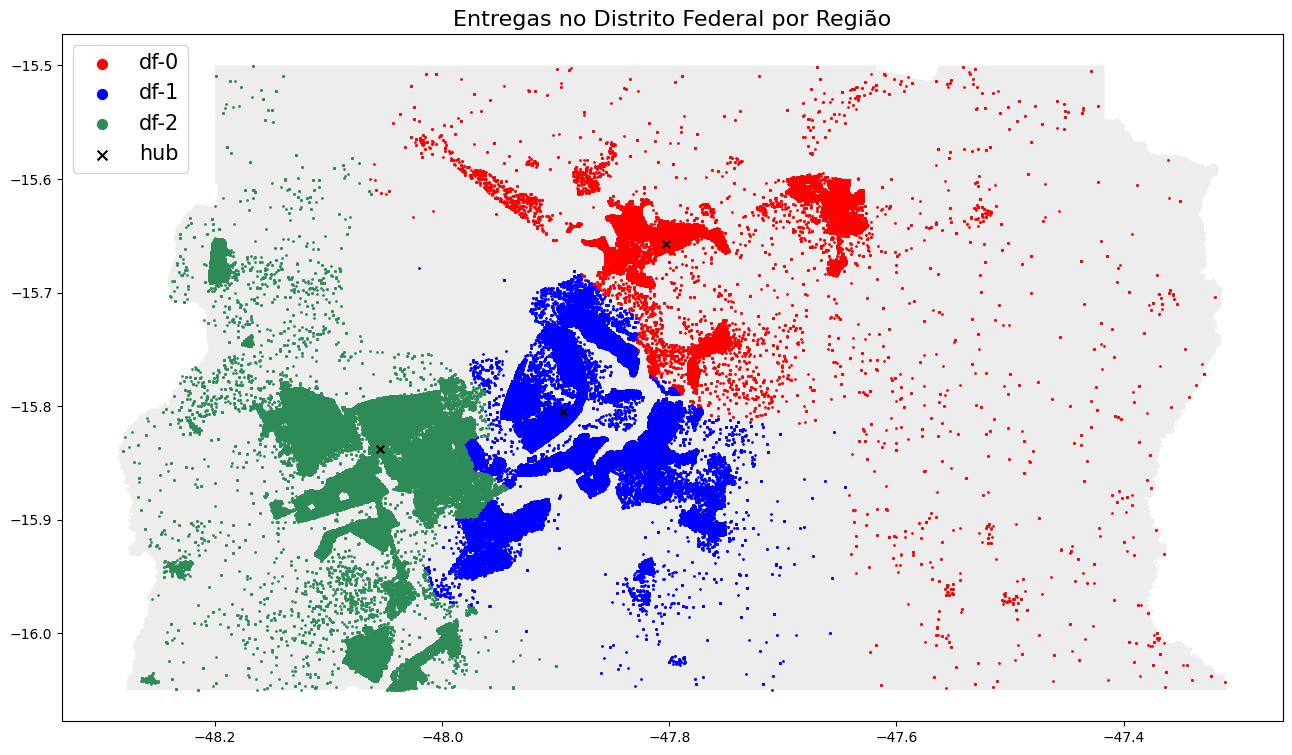

In [41]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (40/2.54, 40/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

Gerei também 4 gráficos. O primeiro é sobre a proporção de entregas por região, assim como o mapa demonstra. Os outros 3 são sobre valores como a quantidade média, minima e máxima de entregas por instância em cada região.

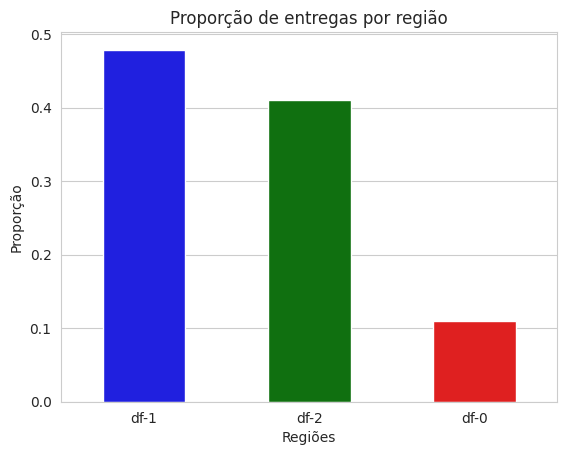

In [114]:
# Gráfico de proporção de entregas por região

data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={'proportion': "region_percent", 0 : "region_percent"}, inplace=True)

cores = {'df-0': 'red', 'df-1': 'blue', 'df-2': 'green'}

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=data, x="region", y="region_percent", errorbar=None, palette=cores, color=cores.values(),width=0.5)
  grafico.set(title='Proporção de entregas por região', xlabel='Regiões', ylabel='Proporção')

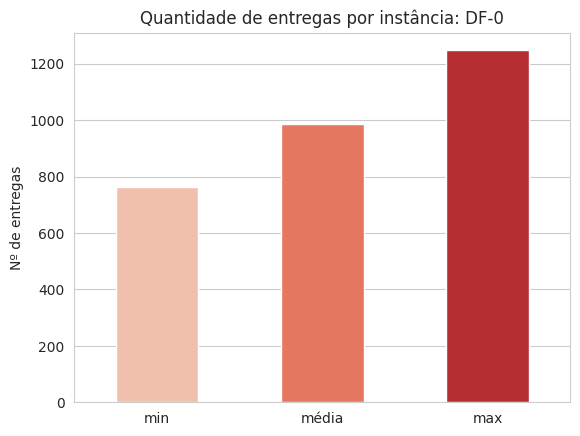

In [118]:
geo_deliveries_df = pd.DataFrame(geo_deliveries_df)

df_region0 = geo_deliveries_df.loc[geo_deliveries_df['region'] == 'df-0']
teste_df = pd.DataFrame(df_region0[['name','geometry','region']].groupby('name').count().sort_values(by='geometry').reset_index())
teste_df = teste_df.describe().T.rename(columns = {'mean':'média'})
teste_df = teste_df[['min','média','max',]].T.reset_index().rename(columns = {'index':'valores','geometry':'entregas'})

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=teste_df, x="valores", y="entregas",errorbar=None,width=0.5,palette='Reds')
  grafico.set(title='Quantidade de entregas por instância: DF-0', xlabel=None, ylabel='Nº de entregas');

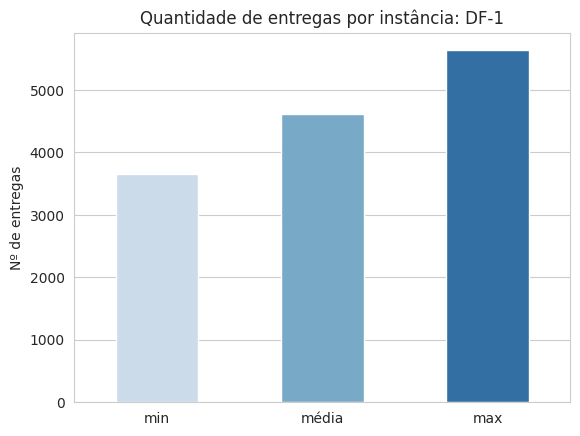

In [116]:
df_region1 = geo_deliveries_df.loc[geo_deliveries_df['region'] == 'df-1']
teste_df1 = pd.DataFrame(df_region1[['name','geometry','region']].groupby('name').count().sort_values(by='geometry').reset_index())
teste_df1 = teste_df1.describe().T.rename(columns = {'mean':'média'})
teste_df1 = teste_df1[['min','média','max',]].T.reset_index().rename(columns = {'index':'valores','geometry':'entregas'})

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=teste_df1, x="valores", y="entregas", errorbar=None,width=0.5,palette='Blues')
  grafico.set(title='Quantidade de entregas por instância: DF-1', xlabel=None, ylabel='Nº de entregas');

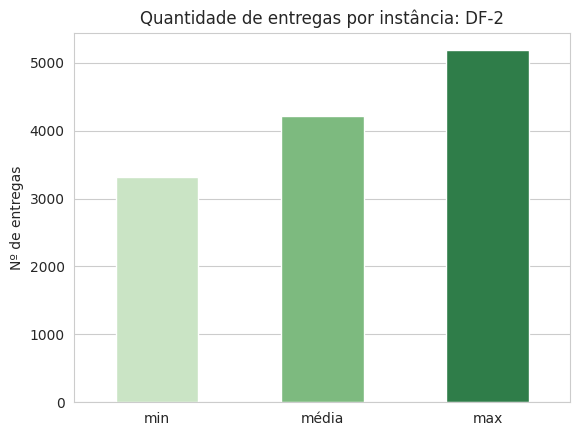

In [119]:
df_region2 = geo_deliveries_df.loc[geo_deliveries_df['region'] == 'df-2']
teste_df2 = pd.DataFrame(df_region2[['name','geometry','region']].groupby('name').count().sort_values(by='geometry').reset_index())
teste_df2 = teste_df2.describe().T.rename(columns = {'mean':'média'})
teste_df2 = teste_df2[['min','média','max',]].T.reset_index().rename(columns = {'index':'valores','geometry':'entregas'})

with sns.axes_style('whitegrid'):
  grafico = sns.barplot(data=teste_df2, x="valores", y="entregas", errorbar=None,width=0.5,palette='Greens')
  grafico.set(title='Quantidade de entregas por instância: DF-2', xlabel=None, ylabel='Nº de entregas');

## 6\. Resultado


Pelo que é possivel ver pelos gráficos criados, a região DF-0 é onde tem menos entregas no geral. Isso se deve a questão topográfica da própria região de brasilia, pois a região DF-0 é onde a densidade populacional é bem menor comparada as outras regiões. Enquanto que a região DF-1 é a com maior número de entregas feitas, muito provavelmente por ser a região central.

Também é possivel perceber que os dados da Loggi possuem poucos valores nulos no geral, o que não chegou a atrapalhar a análise.